In [4]:
import sys
sys.path.append('../src')

In [5]:
import pandas as pd
import numpy as np
from utils import quick_eda

df_train = pd.read_csv('../data/playground-series-s5e3/train.csv')
quick_eda(df_train)

Shape: 2190 rows and 13 columns
Duplicates check: 0 duplicate rows found

Sample data:


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


Data types and missing count:


,dtype,non_missing,missing,missing_pct
id,int64,2190,0,0.0
day,int64,2190,0,0.0
pressure,float64,2190,0,0.0
maxtemp,float64,2190,0,0.0
temparature,float64,2190,0,0.0
mintemp,float64,2190,0,0.0
dewpoint,float64,2190,0,0.0
humidity,float64,2190,0,0.0
cloud,float64,2190,0,0.0
sunshine,float64,2190,0,0.0


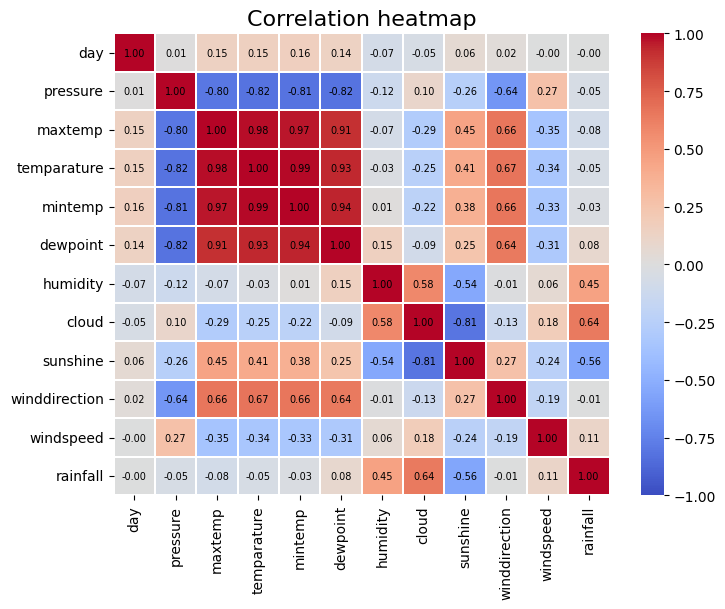

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df_train.drop(columns='id').corr()

plt.figure(figsize=(8, 6))

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.01,
    annot=True,
    annot_kws={'fontsize':7, 'color': 'black'},
    fmt='.2f'
)

plt.title('Correlation heatmap', fontsize=16)
plt.show()

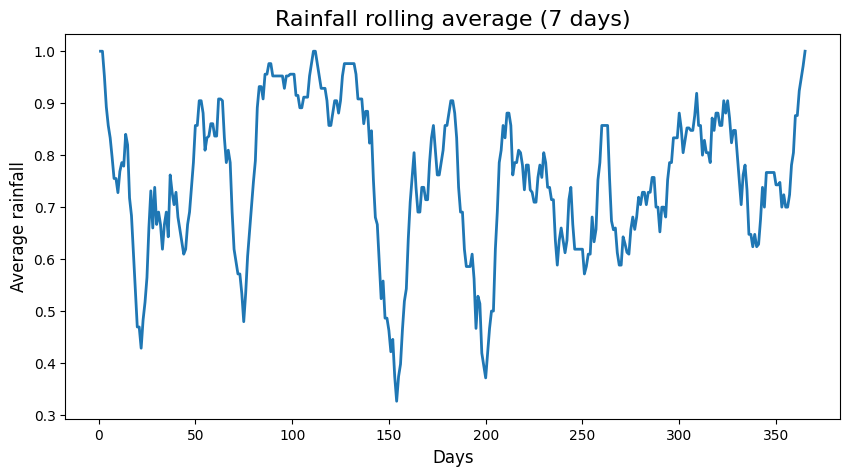

In [7]:
def rolling_average(df, time_var, outcomes, window = 7):

    if isinstance(outcomes, str):
        outcomes = [outcomes]
    
    grouped_df = (
        df
        .groupby(time_var, as_index=False)
        .agg({var: 'mean' for var in outcomes})
    )

    rolling_avg = grouped_df.copy()

    for var in outcomes:
        rolling_avg[var] = (
            grouped_df[var]
            .rolling(window=window, min_periods=1)
            .mean()
        )

    if len(outcomes) > 1:
        return rolling_avg.melt(id_vars=time_var, var_name='variables', value_name='values')
    else:
        return rolling_avg

time_series = rolling_average(df_train, 'day', 'rainfall', window=7)

plt.figure(figsize=(10, 5))
plt.plot(time_series['day'], time_series['rainfall'], linewidth=2)
plt.title('Rainfall rolling average (7 days)', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Average rainfall', fontsize=12)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

target = 'rainfall'

x = df.drop(target, axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

df_train = x_train.merge(y_train, left_index=True, right_index=True)
df_test = x_test.merge(y_test, left_index=True, right_index=True)

In [ ]:
time_series = (
    df_train
    .groupby('day', as_index=False)
    .agg({'rainfall': 'mean', 'humidity': 'mean', 'cloud': 'mean', 'sunshine': 'mean'})
    .melt(id_vars='day', var_name='variables', value_name='values')
)

(
    ggplot(time_series)
    + aes(x='day', y='values', colour='variables')
    + geom_line(show_legend=False)
    + facet_wrap('variables', scales='free_y')
    + theme_bw()
)

In [ ]:
def rolling_average(df, x, y, window = 7):

    grouped_df = (
        df
        .groupby(x, as_index=False)
        .agg({var: 'mean' for var in y})
    )

    rolling_avg = grouped_df.copy()

    rolling_avg[y] = (
        grouped_df[y]
        .rolling(window=window, min_periods=1)
        .mean()
    )

    melted_rolling_avg = rolling_avg.melt(id_vars=x, var_name='variables', value_name='values')

    return melted_rolling_avg

time_series = rolling_average(df_train, 'day', ['rainfall', 'humidity', 'cloud', 'sunshine'], window=7)

(
    ggplot(time_series)
    + aes(x='day', y='values', colour='variables')
    + geom_line(show_legend=False)
    + facet_wrap('variables', scales='free_y')
    + theme_bw()
)


In [ ]:
def add_lags(df, id_col, time_col, lag=7):
    cols_to_lag = [col for col in df.columns if col not in [id_col, time_col]]
    
    new_df = (
        df
        .sort_values(by=[id_col, time_col])
        .assign(**{
            **{f'{col}_lag_{lag}': df[col].shift(lag) 
               for col in cols_to_lag}
        })
    )

    return new_df

df_train_lags = add_lags(df_train, 'id', 'day', 7)
df_train_lags.head()

In [ ]:
sns.heatmap(
    df_train_lags.filter(regex='rainfall|lag').corr(),
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.01,
    annot=True,
    annot_kws={'fontsize':7, 'color': 'black'},
    fmt='.2f'
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(x_train, y_train)

def get_model_score(x_test, y_test, model):
    y_prob = model.predict_proba(x_test)[:, 1]
    score = roc_auc_score(y_test, y_prob)
    return score, y_prob

score, y_prob = get_model_score(x_test, y_test, model)

print(f'AUC: {score: .4f}')

In [ ]:
df_test = df_test.assign(y_prob=y_prob)

time_series = rolling_average(df_test, 'day', ['rainfall', 'y_prob'], window=14)

(
    ggplot(time_series)
    + aes(x='day', y='values', colour='variables')
    + geom_line()
    + theme_bw()
)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_df = pd.DataFrame({
    'fpr': fpr,
    'tpr': tpr,
    'threshold': thresholds
})

(
    ggplot(roc_df)
    + aes(x='fpr', y='tpr')
    + geom_line(color='blue')
    + geom_abline(slope=1, intercept=0, color='gray', linetype='--')
    + labs(title = f'Curva ROC (AUC: {score: .4f})')
    + theme_bw()
)

In [ ]:
test = pd.read_csv('../data/playground-series-s5e3/test.csv')
quick_eda(test)

In [ ]:
test.fillna(df_train.median(), inplace=True)
test_prob = model.predict_proba(test)[:, 1]

In [ ]:
submission = pd.read_csv('../data/playground-series-s5e3/sample_submission.csv')
submission['rainfall'] = test_prob
submission.to_csv('../outputs/playground-series-s5e3/submission.csv', index=False)